## Masked Modeling

In [ ]:
pip install torchnet

In [ ]:
pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

## Set Device

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Image

In [ ]:
img_path = 'sample_image.jpg'
mask_path = 'sample_masks.png'

(400, 600, 3)


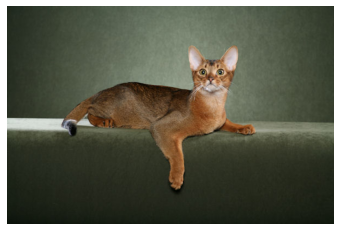

In [ ]:
img = Image.open(img_path).convert("RGB")
print(np.array(img).shape)
plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.show()

(400, 600)


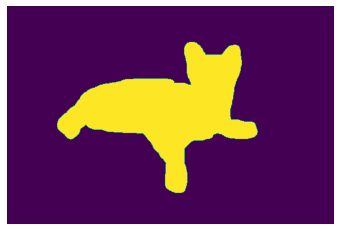

In [ ]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask
    
trimap = np.array(Image.open(mask_path))
masks = preprocess_mask(trimap)
print(masks.shape)
plt.imshow(masks)
plt.grid(False)
plt.axis('off')
plt.show()

## Load Datasets

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ADL Group Project')

In [ ]:
transform = transforms.Compose([transforms.Resize((256, 256)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

transform_y = transforms.Compose([transforms.Resize((256, 256)), 
                                  transforms.ToTensor()])

In [ ]:
X = []
count = 0
image_names = []
for file_name in tqdm(os.listdir(sys.path[-1]+'/sample dataset/images')):
    image_names.append(file_name.split('.')[0])
    if file_name.split('.')[1] != 'jpg':
        continue
    image_path = sys.path[-1]+'/sample dataset/images/'+file_name
    img = Image.open(image_path).convert("RGB")
    x = transform(img)
    X.append(x.unsqueeze(dim=0))
    count += 1
    if count == 150:
        break
X = torch.cat(X, dim=0)
X.shape

 75%|███████▍  | 152/203 [00:01<00:00, 119.83it/s]


torch.Size([150, 3, 256, 256])

In [ ]:
Y = []
count = 0
for file_name in tqdm(image_names):
    masks_path = sys.path[-1]+'/sample dataset/trimaps/'+file_name+'.png'
    trimap = np.array(Image.open(masks_path))
    masks = preprocess_mask(trimap)
    y = transform_y(Image.fromarray((masks).astype(np.uint8)))
    y[y != 0] = 1
    Y.append(y.unsqueeze(dim=0))
    count += 1
    if count == 150:
        break
Y = torch.cat(Y, dim=0)
Y.shape

 97%|█████████▋| 149/153 [00:00<00:00, 219.78it/s]


torch.Size([150, 1, 256, 256])

In [ ]:
X_masked = torch.clone(X)
for i in tqdm(range(X_masked.shape[0])):
    mask = (Y[i] == 1)
    X_masked[i][0][mask.squeeze()] = 0
    X_masked[i][1][mask.squeeze()] = 0
    X_masked[i][2][mask.squeeze()] = 0
X_masked.shape

100%|██████████| 150/150 [00:00<00:00, 5409.31it/s]


torch.Size([150, 3, 256, 256])

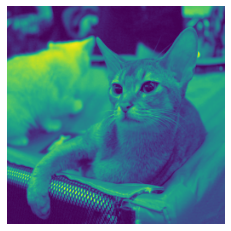

In [ ]:
plt.imshow(X[0].squeeze()[0])
plt.grid(False)
plt.axis('off')
plt.show()

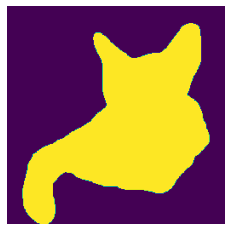

In [ ]:
plt.imshow(Y[0].squeeze())
plt.grid(False)
plt.axis('off')
plt.show()

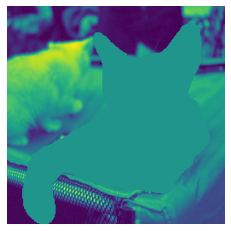

In [ ]:
plt.imshow(X_masked[0].squeeze()[0])
plt.grid(False)
plt.axis('off')
plt.show()

In [ ]:
dataset = TensorDataset([X.float(), X_masked.float()])
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
print('Datasets ready!')

Datasets ready!


## DeepLab3v+

In [ ]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",         # use ResNet50 as backbone
    encoder_weights="imagenet",      # use pre-trained weights from ImageNet
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    encoder_output_stride=16,        # 16 for semantic segmentation suggested in the paper for best trade-off between speech and accuracy
    decoder_atrous_rates=(6,12,18),  #dilation rates for ASPP, suggested in the paper
    decoder_channels=256,            # number of convolution filters in ASPP module (default=256)
    in_channels=3,                   # number of input channels (default=3, expects RGB images)
    upsampling=4,                    # final upsampling factor (default=4, to preserve input-output spatial shape identity) 
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for RGB image
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)
model.to(device)

## Dimension Check

In [ ]:
x = transform(img)
x = x.unsqueeze(dim=0)
x = x.to(device)
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(x)
outputs.shape

torch.Size([1, 3, 512, 512])

In [ ]:
outputs = outputs.detach().cpu().numpy().squeeze()
outputs.shape

(3, 512, 512)

## Training

In [ ]:
import torch.nn.functional as F


In [ ]:
lr = 1e-4
num_epochs = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    train_loss_i = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        resized_outputs = F.interpolate(outputs, size=(256,256), mode='bilinear', align_corners=False)
        loss = criterion(resized_outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_i += loss.item()
    print('Training loss: {}'.format(train_loss_i/len(train_loader.dataset)))

# torch.save(model.state_dict(), 'trained_model.pth')

100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Training loss: 0.011613395313421886


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Training loss: 0.007569809357325236


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Training loss: 0.005781270315249761


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Training loss: 0.005111731986204783


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Training loss: 0.004620912323395412


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Training loss: 0.00423312857747078


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Training loss: 0.0037833064049482344


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Training loss: 0.0037770525614420573


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Training loss: 0.003424912542104721


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Training loss: 0.003219950720667839


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Training loss: 0.0033456389605998993


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Training loss: 0.0031582969178756077


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.003197578762968381


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Training loss: 0.002830130681395531


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.0026686908801396686


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.002623719150821368


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Training loss: 0.0023733000705639523


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.002276426963508129


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Training loss: 0.002251795083284378


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

Training loss: 0.002111739665269852


In [ ]:
# torch.save(model.state_dict(), 'trained_model.pth')

## Inference

In [ ]:
x = X_masked[5].unsqueeze(dim=0).to(device)
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
model.eval()
with torch.no_grad():
    output = model(x)
output.shape

torch.Size([1, 3, 512, 512])

In [ ]:
output = output.detach().cpu().numpy().squeeze()
print(output.shape)

(3, 512, 512)


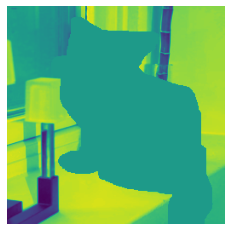

In [ ]:
plt.imshow(X_masked[5].squeeze()[0])
plt.grid(False)
plt.axis('off')
plt.show()

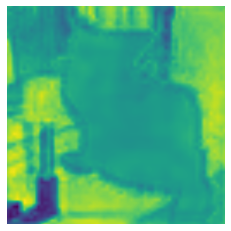

In [ ]:
plt.imshow(output.squeeze()[0])
plt.grid(False)
plt.axis('off')
plt.show()